# GAP Safe Screening Rules for Sparse-Group-Lasso
see http://arxiv.org/abs/1602.06225 for more details

The Sparse-Group-Lasso estimator is defined as
$$\hat \beta^{\lambda, \tau, w} = \underset{{\beta \in \mathbb{R}^p}}{\text{argmin}} \frac{1}{2} \|y - X \beta\|_{2}^{2} + \lambda \left( \tau \|\beta\|_1 + (1-\tau) \sum_{g \in \mathcal{G}} w_g \|\beta_g\|_2 \right). $$


Before going any further, please compile the programs as follows:
- \$ cython sgl_fast.pyx
- \$ python setup.py build_ext --inplace 

A recent version of scipy is mandatory (at least version 0.16.1).

In [1]:
import numpy as np
from sgl_tools import generate_data
from sgl import sgl_path
import time
import matplotlib.pyplot as plt
import pandas as pd

The different screening rules proposed are

# Experiments on synthetic data:

We use the model $y = X \beta + 0.01 \varepsilon$ where $\varepsilon
\sim \mathcal{N}(0, \text{Id}_n)$, $X \in \mathbb{R}^{n \times p}$ follows a multivariate
normal distribution with pairwise correlation such that $\forall (i,j) \in [p]^2, \text{corr}(X_i, X_j) =
\rho^{|i-j|}$. We select $10\%$ of the groups to be active and in each of the selected groups, $10\%$ of the
coordinates are drawn such that $[\beta_g]_j = \text{sign}(\xi) \times U$ where
$U$ is uniform in $[0.5, 10])$ and $\xi$ uniform in $[-1, 1]$ and the others are set to zero.

We run the algorithm with a sequence $(\lambda_t)_{t \in [T-1]}$ defined as 
$\lambda_t: = \lambda_{\max} 10^{- \frac{\delta t}{T - 1}}$. By default, we choose $\delta = 3$, $T=100$, $\rho=0.5$ and $\tau=0.5$. All this parameters can be passed as an argument.

Note that the group structure is managed (for convenience) with the array size_groups that contains the sizes of all groups. For example,
$\beta \in \mathbb{R}^{7}$ given by $\beta = \{(-3, 0), (0.1, 0.2, 5), (4, -8)\}$ with
size_groups $= \{2, 3, 2\}$.

In [2]:
n_samples = 100
n_features = 500
size_group = 50 # all groups have size = size_group

size_groups = size_group * np.ones(n_features / size_group, order='F', dtype=np.intc)
X, y = generate_data(n_samples, n_features, size_groups, rho=0.4)
omega = np.sqrt(size_groups)

# Benchmark
We compare different screening rules described in for different specified accuracy on the duality gap
and with default parameters. 

In [3]:
NO_SCREEN = 0
STATIC_SAFE = 1
DYNAMIC_SAFE = 2
DST3 = 3
GAPSAFE_SEQUENTIAL = 4
GAPSAFE = 5

screenings = [NO_SCREEN, STATIC_SAFE, DYNAMIC_SAFE, DST3, GAPSAFE_SEQUENTIAL, GAPSAFE]
screenings_names = ["NO SCREENING", "STATIC SAFE", "DYNAMIC SAFE", "DST3", "GAP SAFE SEQUENTIAL", "GAP SAFE"]

In [4]:
%matplotlib notebook
plt.style.use('ggplot')

In [5]:
eps_ = range(4, 10, 2)
times = np.zeros((len(screenings),len(eps_)))
for ieps, eps in enumerate(eps_):
    for iscreening, screening in enumerate(screenings):

        begin = time.time()
        
        coefs, dual_gaps, lambdas, screening_size_groups, screening_size_features, n_iters = \
           sgl_path(X, y, size_groups, omega, screening, eps=10**(-eps))

        duration = time.time() - begin
        times[iscreening, ieps] = duration

Now we show the duality gap (which is our stopping criterion) as a function of lambdas. 

<IPython.core.display.Javascript object>


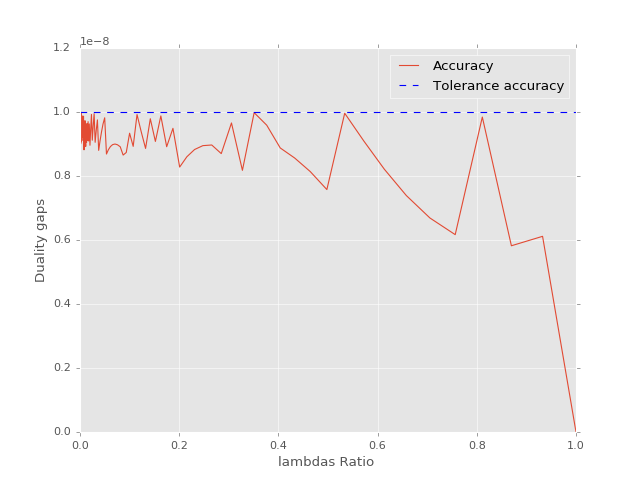

In [6]:
l1 = plt.plot(lambdas / lambdas[0], dual_gaps, label="Accuracy")
plt.axhline(10**(-eps), linestyle='--', color='b', label="Tolerance accuracy")
plt.xlabel(r"lambdas Ratio ")
plt.ylabel(r"Duality gaps")
plt.ylim(ymax= 1.2 * 10**(-eps))
plt.legend(loc='best')
plt.show()

Here we display the computational times to reach convergence as a function of duality gap for the different screening rules.

<IPython.core.display.Javascript object>


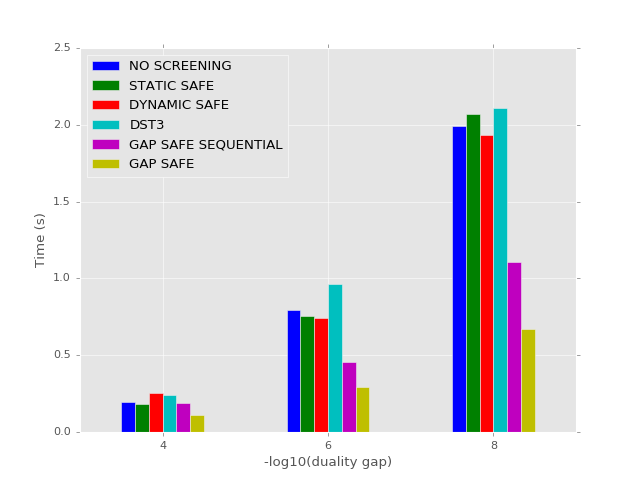

In [7]:
df = pd.DataFrame(times.T, columns=screenings_names)
df.plot(kind='bar', rot=0)
plt.xticks(range(len(eps_)), [str(t) for t in eps_])
plt.xlabel("-log10(duality gap)")
plt.ylabel("Time (s)")
plt.grid(color='w')
leg = plt.legend(loc='best')
plt.show()